In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import numpy as np

In [3]:
# Set the specified hyperparameters
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
Batch_size = 128
epochs = 200
step_size = 5
gamma = 0.1
num_classes = 10
threshold = 0.1

In [4]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
def calculate_center_si(data, label):
    n_data, n_feature = data.shape
    n_class = label.max().item() + 1

    # Ensure label is a 1D tensor for proper indexing
    label = label.squeeze().to(device)

    # Create a tensor to store the class centers
    class_centers = torch.zeros(n_class, n_feature, device=data.device)

    # Efficient computation of class centers for any number of features
    for i in range(n_class):
        class_members = data[label == i]
        if len(class_members) > 0:
            class_centers[i] = class_members.mean(0)

    # Compute distances to class centers
    dis_matrix = torch.cdist(data, class_centers, p=2)

    # Find the nearest class center for each data point
    _, nearest_center_labels = torch.min(dis_matrix, dim=1)

    # Calculate CSI
    csi = torch.sum(nearest_center_labels == label).float() / n_data

    return csi
def calculate_si(data, label):
    n_data = data.shape[0]

    dis_matrix = torch.cdist(data, data, p=2)
    dis_matrix.fill_diagonal_(1e10)

    # Find the nearest neighbor for each data point
    _, nearest_neighbors = torch.min(dis_matrix, dim=1)

    # Calculate SI by comparing labels of each data point with its nearest neighbor
    si = torch.sum(label == label[nearest_neighbors]).float() / n_data

    return si

def forward_feature_ranking_si(data, label, n_feature, big_number=1e10):
    device1 = data.device
    ranked_features = torch.empty(0, dtype=torch.long, device=device1)
    rest_features = torch.arange(n_feature, device=device1)
    si_ranked_features = torch.zeros(n_feature, device=device1)

    for k_forward in range(n_feature):
        si_max = 0
        chosen_feature = None
        k_search_chosen = None

        for k_search in range(rest_features.numel()):
            current_feature = rest_features[k_search]

            # Selecting the current set of features
            features_subset = torch.cat((ranked_features, current_feature.unsqueeze(0)))

            # Calculate SI for the current subset of features
            current_si = calculate_si(data[:, features_subset], label)

            if current_si > si_max:
                si_max = current_si
                chosen_feature = current_feature
                k_search_chosen = k_search

        ranked_features = torch.cat((ranked_features, chosen_feature.unsqueeze(0)))
        rest_features = torch.cat((rest_features[:k_search_chosen], rest_features[k_search_chosen + 1:]))
        si_ranked_features[k_forward] = si_max

    return si_ranked_features, ranked_features


In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transform for validation and test sets remains the same
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with appropriate transforms
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Splitting the training set into training and validation sets
train_size = int(0.9 * len(full_train_set))
validation_size = len(full_train_set) - train_size
train_set, validation_set = random_split(full_train_set, [train_size, validation_size])

# Use the non-augmented transform for the validation set
validation_set.dataset.transform = test_transform

# Data loaders
train_loader = DataLoader(train_set, batch_size=Batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=Batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 81236690.93it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [23]:
def train(model, Epoch, optimizer, step_size, gamma, early_stopping_patience=5, min_delta=0.0001):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Initialize StepLR
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(Epoch):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{Epoch}')
        for inputs, labels in pbar:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / total)
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(validation_loss / total)
        val_accuracies.append(100 * correct / total)

        # Update learning rate
        scheduler.step()

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}%')

        # Early stopping check
        val_loss = val_losses[-1]
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }


def my_plot(hist , name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist['train_losses'], label='Training Loss')
    plt.plot(hist['val_losses'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(hist['train_accuracies'], label='Training Accuracy')
    plt.plot(hist['val_accuracies'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.suptitle(name)
    plt.show()
def test(model):
    # Evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

def layerWise_center_si_groupwise(model, data_loader, device):
    si_all = []
    grouped_models = []

    features = list(model.features)
    classifier = list(model.classifier)
    all_layers = features + [model.avgpool, nn.Flatten(start_dim=1)] + classifier

    # Group layers (Conv, ReLU, MaxPool)
    grouped_layers = []
    temp_group = []
    for layer in all_layers:
        temp_group.append(layer)
        if isinstance(layer, (nn.MaxPool2d, nn.AdaptiveAvgPool2d, nn.Flatten)):
            grouped_layers.append(temp_group)
            temp_group = []
    if temp_group:
        grouped_layers.append(temp_group)

    for i, group in enumerate(grouped_layers):
        sub_model = nn.Sequential(*(sum(grouped_layers[:i+1], [])))
        sub_model.to(device)
        grouped_models.append(sub_model)

        with torch.no_grad():
            output_all = []
            label_all = []
            batch_counter = 0
            for data, label in data_loader:
                data = data.to(device)
                output = sub_model(data)
                outputs = torch.flatten(output, start_dim=1)
                output_all.append(outputs)
                label_all.append(label)
                batch_counter += 1
                if batch_counter>= 50:
                  break

            output_all = torch.cat(output_all, dim=0)
            label_all = torch.reshape(torch.cat(label_all, dim=0), (output_all.shape[0], 1))

            center_si = calculate_center_si(output_all, label_all)
            si_all.append(center_si)

            print(f"Group {i}, Output Shape: {output.shape}, Center SI is: {center_si}")

    return si_all, grouped_models

def count_parameters(model): return sum(p.numel() for p in model.parameters())

def layerWise_center_si(model, data_loader, device):
    si_all = []

    features = list(model.base_model)
    all_layers = features + [model.flatten , model.feature_selection , model.fc1 , model.dropout , model.fc2]

    for i, layer in enumerate(all_layers):
        # Create a sub-model with the first 'i' layers
        sub_model = nn.Sequential(*all_layers[:i])
        sub_model.to(device)

        with torch.no_grad():
            output_all = []
            label_all = []
            batch_counter = 0
            for data, label in data_loader:
                # Process the data through the sub-model
                data = data.to(device)
                output = sub_model(data)

                # Flatten the output
                outputs = torch.flatten(output, start_dim=1)

                output_all.append(outputs)
                label_all.append(label)

                batch_counter += 1
                if batch_counter >= 5:
                    break

            # Concatenate all outputs and labels
            output_all = torch.cat(output_all, dim=0)
            label_all = torch.reshape(torch.cat(label_all, dim=0), (output_all.shape[0], 1))

            # Calculate Center SI
            center_si = calculate_center_si(output_all, label_all)
            si_all.append(center_si)
            print(f"Layer {i}, Output Shape: {output.shape}, Center SI is: {center_si}")

    return si_all

In [8]:
model = models.vgg16(weights=None)
model.classifier[3] = nn.Linear(4096, 1024)
model.classifier[6] = nn.Linear(1024, 10)
checkpoint = torch.load('/content/drive/MyDrive/Tahlil_Tarahi/HW04/TT_HW04_Q1_a_vgg16.pth')

model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
si_values, grouped_models = layerWise_center_si_groupwise(model , train_loader , device )

Group 0, Output Shape: torch.Size([128, 64, 16, 16]), Center SI is: 0.504687488079071
Group 1, Output Shape: torch.Size([128, 128, 8, 8]), Center SI is: 0.6153124570846558
Group 2, Output Shape: torch.Size([128, 256, 4, 4]), Center SI is: 0.7479687333106995
Group 3, Output Shape: torch.Size([128, 512, 2, 2]), Center SI is: 0.8532812595367432
Group 4, Output Shape: torch.Size([128, 512, 1, 1]), Center SI is: 0.9309374690055847
Group 5, Output Shape: torch.Size([128, 512, 7, 7]), Center SI is: 0.9345312118530273
Group 6, Output Shape: torch.Size([128, 25088]), Center SI is: 0.9232812523841858
Group 7, Output Shape: torch.Size([128, 10]), Center SI is: 0.9426562190055847


In [13]:
best_model = grouped_models[4]

In [15]:
X_train = []
y_train = []
batch_counter = 0
for i, j in train_loader:
    k = best_model(i.to(device))
    X_train.append(k)
    y_train.append(j)
    batch_counter+=1
    if batch_counter>=50:
      break
X_train = [tensor.squeeze() for tensor in X_train]
y_train = [tensor.squeeze() for tensor in y_train]

X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)


In [16]:
si_ranked_features, ranked_features = forward_feature_ranking_si(X_train , y_train.to(device) , 512)


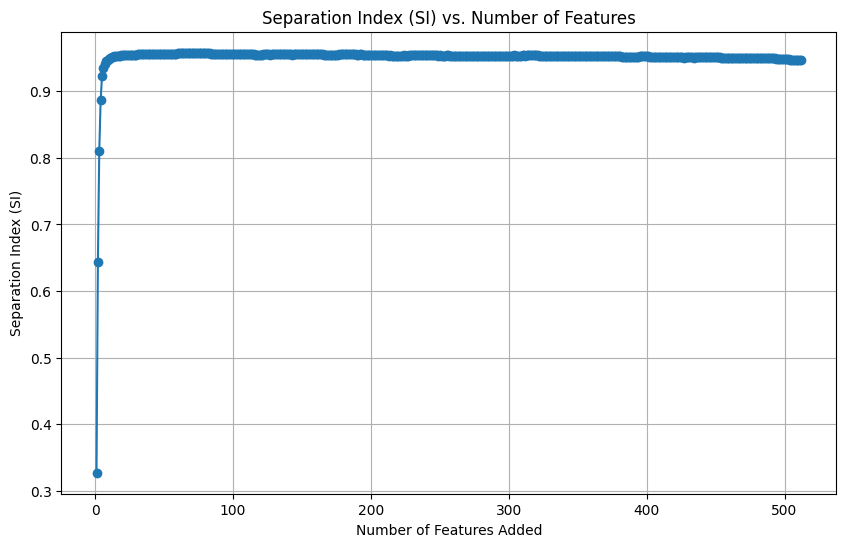

In [13]:
si_values = si_ranked_features.tolist()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 513), si_values, marker='o', linestyle='-')
plt.title('Separation Index (SI) vs. Number of Features')
plt.xlabel('Number of Features Added')
plt.ylabel('Separation Index (SI)')
plt.grid(True)
plt.show()

In [10]:
class FeatureSelectionLayer(nn.Module):
    def __init__(self, indices):
        super(FeatureSelectionLayer, self).__init__()
        self.indices = torch.tensor(indices, dtype=torch.long)

    def forward(self, x):
        # Select features based on the provided indices
        return x[:, self.indices]


In [9]:
class ExtendedModel(nn.Module):
    def __init__(self, base_model, feature_indices, num_classes):
        super(ExtendedModel, self).__init__()
        self.base_model = base_model

        # Freeze the parameters in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        self.feature_selection = FeatureSelectionLayer(feature_indices)
        self.pooling = nn.AdaptiveAvgPool1d(1)  # GlobalAveragePooling equivalent
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(len(feature_indices), 100)  # Dense layer
        self.fc2 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.feature_selection(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

In [17]:
extended_model = ExtendedModel(best_model, ranked_features[:250], num_classes)


<ipython-input-10-86dc074d1d3d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(indices, dtype=torch.long)


In [35]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(extended_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

extended_model.to(device)
# Train the model using your training loop
history = train(extended_model, epochs, optimizer, step_size, gamma)

Epoch 1/200: 100%|██████████| 352/352 [00:19<00:00, 18.16it/s]


Epoch 1, Train Loss: 0.013977505085203382, Train Accuracy: 49.71111111111111%, Validation Loss: 0.009339620339870453, Validation Accuracy: 66.06%


Epoch 2/200: 100%|██████████| 352/352 [00:20<00:00, 17.30it/s]


Epoch 2, Train Loss: 0.008046173636118571, Train Accuracy: 66.94888888888889%, Validation Loss: 0.007034075087308884, Validation Accuracy: 67.3%


Epoch 3/200: 100%|██████████| 352/352 [00:19<00:00, 18.44it/s]


Epoch 3, Train Loss: 0.006913335133923425, Train Accuracy: 68.78%, Validation Loss: 0.005871924495697021, Validation Accuracy: 76.82%


Epoch 4/200: 100%|██████████| 352/352 [00:20<00:00, 17.26it/s]


Epoch 4, Train Loss: 0.005227606944905387, Train Accuracy: 77.34666666666666%, Validation Loss: 0.004854839789867401, Validation Accuracy: 77.02%


Epoch 5/200: 100%|██████████| 352/352 [00:19<00:00, 18.37it/s]


Epoch 5, Train Loss: 0.004054980399873522, Train Accuracy: 85.90222222222222%, Validation Loss: 0.003615798741579056, Validation Accuracy: 86.74%


Epoch 6/200: 100%|██████████| 352/352 [00:19<00:00, 17.70it/s]


Epoch 6, Train Loss: 0.0036288030750221676, Train Accuracy: 86.74888888888889%, Validation Loss: 0.003468197837471962, Validation Accuracy: 86.76%


Epoch 7/200: 100%|██████████| 352/352 [00:20<00:00, 17.09it/s]


Epoch 7, Train Loss: 0.0035983089930481382, Train Accuracy: 86.7088888888889%, Validation Loss: 0.0034597329288721087, Validation Accuracy: 86.78%


Epoch 8/200: 100%|██████████| 352/352 [00:19<00:00, 17.63it/s]


Epoch 8, Train Loss: 0.0035765243020322588, Train Accuracy: 86.68%, Validation Loss: 0.0034494971811771394, Validation Accuracy: 86.78%


Epoch 9/200: 100%|██████████| 352/352 [00:19<00:00, 18.27it/s]


Epoch 9, Train Loss: 0.0035426296727524864, Train Accuracy: 86.74444444444444%, Validation Loss: 0.003530084651708603, Validation Accuracy: 86.78%


Epoch 10/200: 100%|██████████| 352/352 [00:19<00:00, 17.66it/s]


Epoch 10, Train Loss: 0.0034886791858408186, Train Accuracy: 86.86888888888889%, Validation Loss: 0.003401844561100006, Validation Accuracy: 86.82%


Epoch 11/200: 100%|██████████| 352/352 [00:19<00:00, 17.98it/s]


Epoch 11, Train Loss: 0.003473162472910351, Train Accuracy: 86.82222222222222%, Validation Loss: 0.0034081768691539764, Validation Accuracy: 86.82%
Early stopping triggered after epoch 11


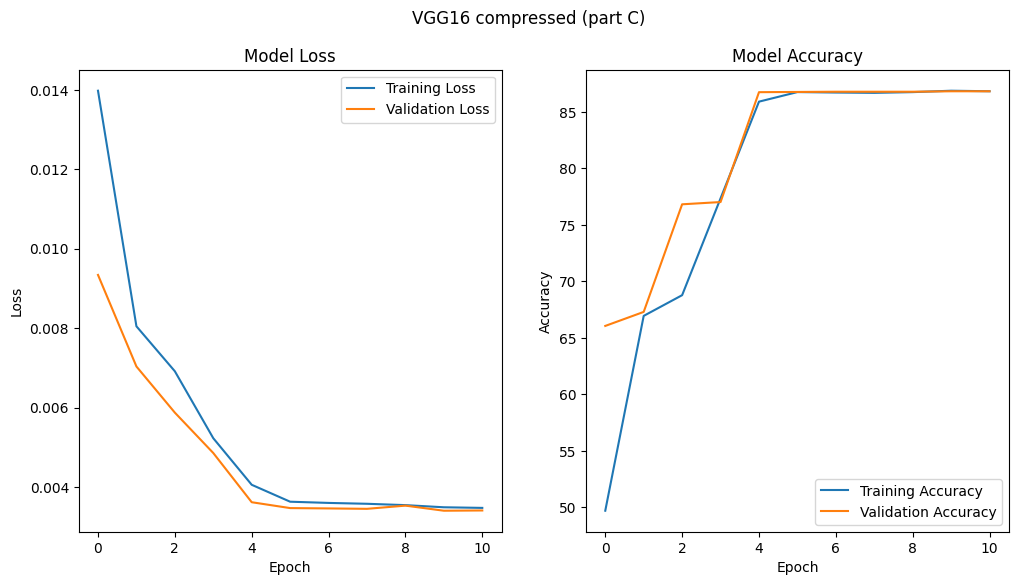

In [37]:
my_plot(history , 'VGG16 Compressed (part C)')

In [36]:
test(extended_model)

Accuracy of the network on the 10000 test images: 75 %


In [41]:
print(f'number of parameters for compressed model : {count_parameters(extended_model)}')

number of parameters for compressed model : 14740798


In [42]:
print(f'number of parameters for original model : {count_parameters(model)}')

number of parameters for original model : 121684810


In [48]:
# Save metrics
torch.save({
    'epoch': 15,
    'model_state_dict': extended_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': history.get("train_losses"),
    'train_accuracies': history.get("train_accuracies"),
    'val_losses': history.get("val_losses"),
    'val_accuracies': history.get("val_accuracies"),
}, '/content/drive/MyDrive/Tahlil_Tarahi/HW04/TT_HW04_Q1_c_vgg16.pth')

In [21]:
extended_model = ExtendedModel(best_model, ranked_features[:250], num_classes)

checkpoint = torch.load('/content/drive/MyDrive/Tahlil_Tarahi/HW04/TT_HW04_Q1_c_vgg16.pth')

extended_model.load_state_dict(checkpoint['model_state_dict'])

extended_model.to(device)

<ipython-input-10-86dc074d1d3d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(indices, dtype=torch.long)


ExtendedModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [24]:
layer_si = layerWise_center_si(extended_model , train_loader , device)

Layer 0, Output Shape: torch.Size([128, 3, 32, 32]), Center SI is: 0.28437501192092896
Layer 1, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.41093751788139343
Layer 2, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.5328125357627869
Layer 3, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.596875011920929
Layer 4, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.7250000238418579
Layer 5, Output Shape: torch.Size([128, 64, 16, 16]), Center SI is: 0.6875
Layer 6, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.707812488079071
Layer 7, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.78125
Layer 8, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.6781250238418579
Layer 9, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.8421875238418579
Layer 10, Output Shape: torch.Size([128, 128, 8, 8]), Center SI is: 0.776562511920929
Layer 11, Output Shape: torch.Size([128, 256, 8, 8]), Center SI 

In [26]:
layer_si_test = layerWise_center_si(extended_model , test_loader , device)

Layer 0, Output Shape: torch.Size([128, 3, 32, 32]), Center SI is: 0.32343751192092896
Layer 1, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.4078125059604645
Layer 2, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.5171875357627869
Layer 3, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.604687511920929
Layer 4, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.7093750238418579
Layer 5, Output Shape: torch.Size([128, 64, 16, 16]), Center SI is: 0.6937500238418579
Layer 6, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.7171875238418579
Layer 7, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.7640625238418579
Layer 8, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.7109375
Layer 9, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.8500000238418579
Layer 10, Output Shape: torch.Size([128, 128, 8, 8]), Center SI is: 0.785937488079071
Layer 11, Output Shape: torch.Size([128, 256, 8, 8

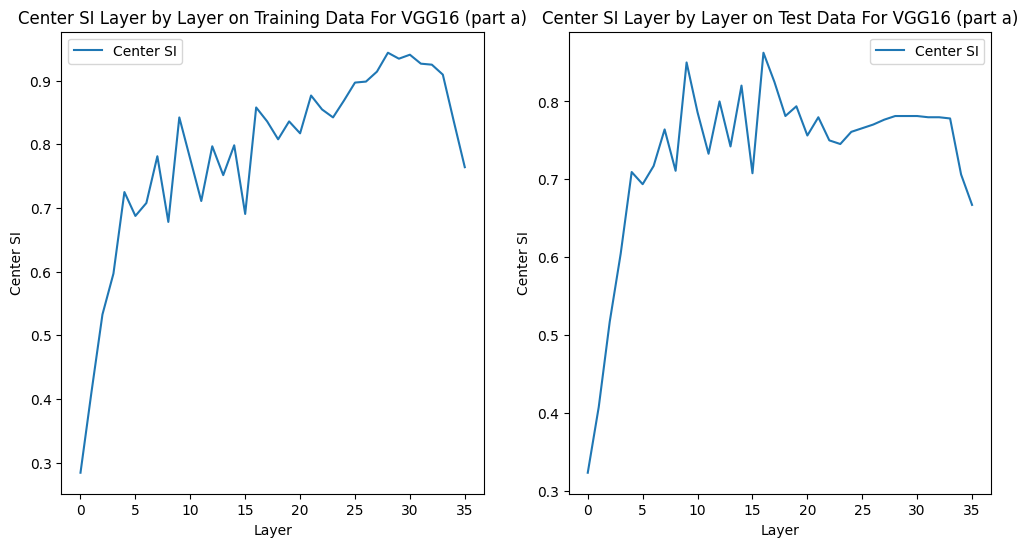

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
plt.plot(torch.tensor(layer_si, device = 'cpu'), label='Center SI')
plt.title('Center SI Layer by Layer on Training Data For VGG16 (part a)')
plt.xlabel('Layer')
plt.ylabel('Center SI')
plt.legend()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 2)
plt.plot(torch.tensor(layer_si_test, device = 'cpu'), label='Center SI')
plt.title('Center SI Layer by Layer on Test Data For VGG16 (part a)')
plt.xlabel('Layer')
plt.ylabel('Center SI')
plt.legend()

plt.show()